<a href="https://colab.research.google.com/github/dipakphp/Climate-Change-Modeling/blob/main/Climate_Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Climate Change Modeling

1. SETUP AND INSTALLATIONS


In [1]:
# Install required libraries
!pip install textblob vaderSentiment wordcloud transformers torch
!python -m textblob.download_corpora

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 12.4 MB/s eta 0:00:00
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import re
from collections import Counter

In [3]:
# NLP libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Sentiment Analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
from wordcloud import WordCloud

# ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

2. LOAD AND EXPLORE DATA

In [6]:
# Load the dataset
# Upload your climate_nasa.csv file to Colab first
df = pd.read_csv('climate_nasa.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (522, 5)

First few rows:
                       date  likesCount  \
0  2022-09-07T17:12:32.000Z           2   
1  2022-09-08T14:51:13.000Z           0   
2  2022-09-07T17:19:41.000Z           1   
3  2022-09-08T00:51:30.000Z           4   
4  2022-09-07T19:06:20.000Z          16   

                                                        profileName  \
0  4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d352303be10b372bb85   
1  518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b3c2c2d6abb7187f432   
2  d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1700531f795584253ab   
3  37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f29836974fb762ded792   
4  e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb5a4a60114bdb7b1d5f   

   commentsCount  \
0            NaN   
1            NaN   
2            3.0   
3            NaN   
4           26.0   

                                                                                                  text  
0  Neat comparison I have not heard it before.\

3. DATA PREPROCESSING

In [7]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_name()
df['quarter'] = df['date'].dt.quarter

# Handle missing values in text
df['text'] = df['text'].fillna('')
df['commentsCount'] = df['commentsCount'].fillna(0)

# Remove duplicates
df = df.drop_duplicates(subset=['text', 'date'], keep='first')

print(f"\n✅ Data preprocessed. Final shape: {df.shape}")

# Text Cleaning Function
def clean_text(text):
    """Clean and preprocess text data"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Remove very short comments (less than 3 words)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 3]

print(f"✅ Text cleaned. Remaining comments: {len(df)}")


✅ Data preprocessed. Final shape: (522, 9)
✅ Text cleaned. Remaining comments: 447


4. EXPLORATORY DATA ANALYSIS (EDA)

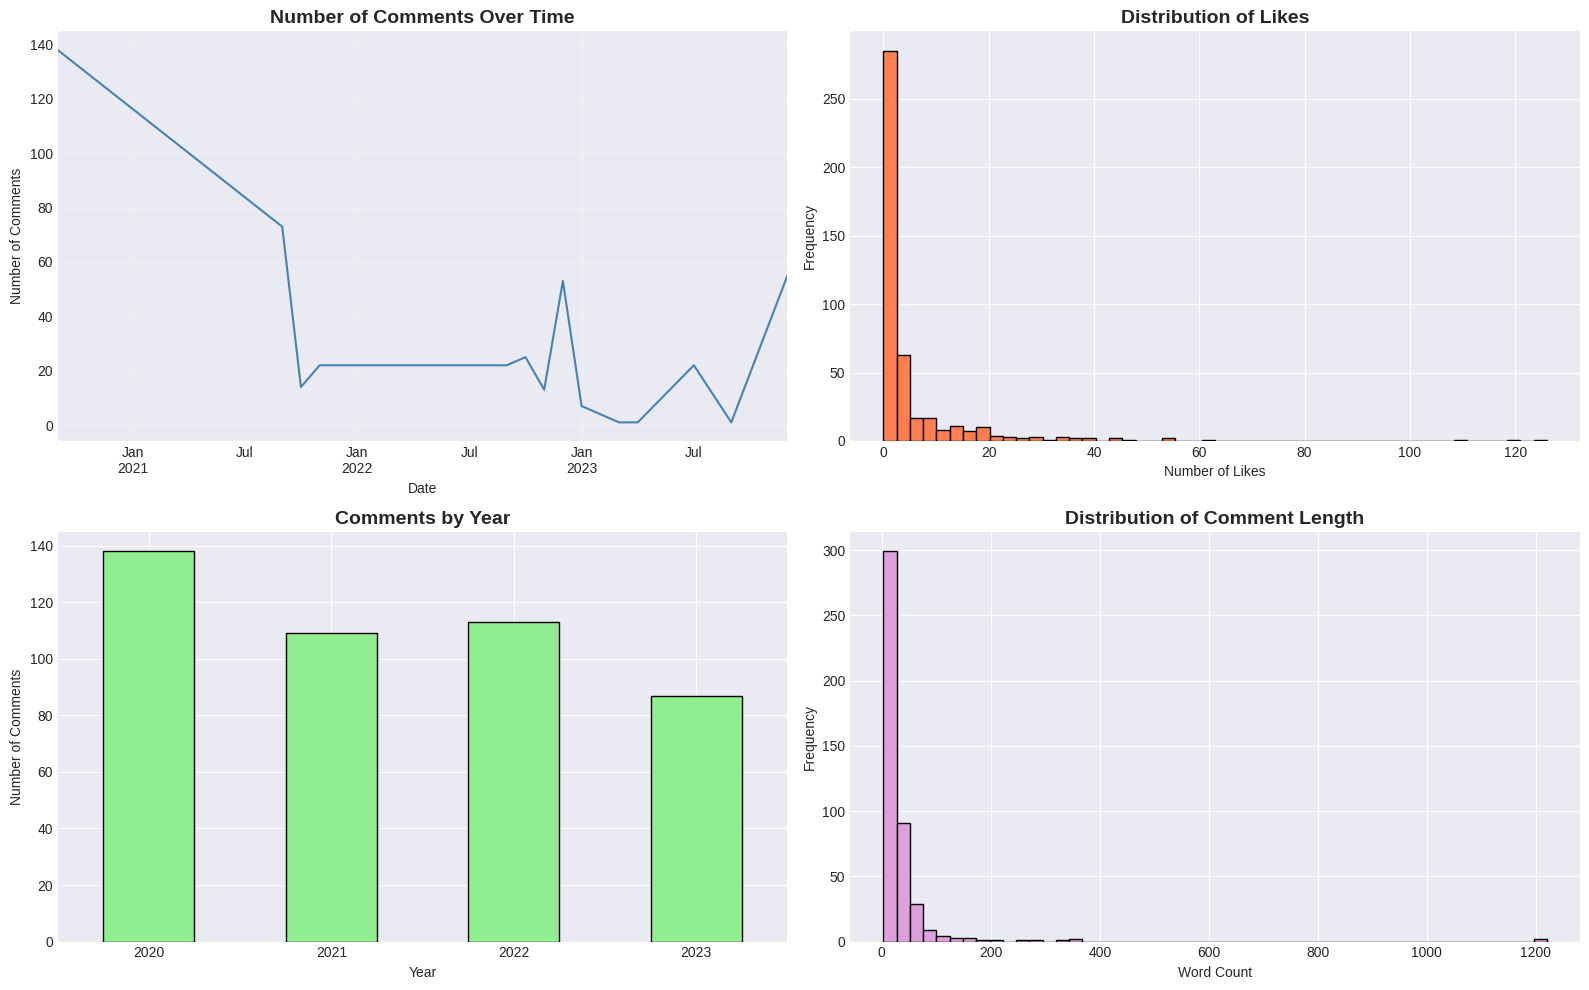


📊 Top 10 Most Liked Comments:
                                                                                                    text  \
433  I can only hope to someday attain the level of patience the person running NASA’s social media has.   
397  You are being gas-lighted. Have any of you heard at any time how the science of global temperatu...   
126                          I love watch NASA dunk on people who think they can "debunk" climate change   
427  Too bad we don’t see Oct 1821 or 1721, just keep going back and you will find the medieval warmi...   
450  To those who cite a very cold day as evidence against global warming, Stephen Colbert once said ...   
213    I'm kinda surprised that the trolls blaming "Earth's natural cycles" haven't already chimed in...   
502  Waiting for the science illiterates to come tell us how it's all a scam. Because math and chemis...   
110  It's worth remembering that land surfaces (red, in the graph below) warm at about twice the rate... 

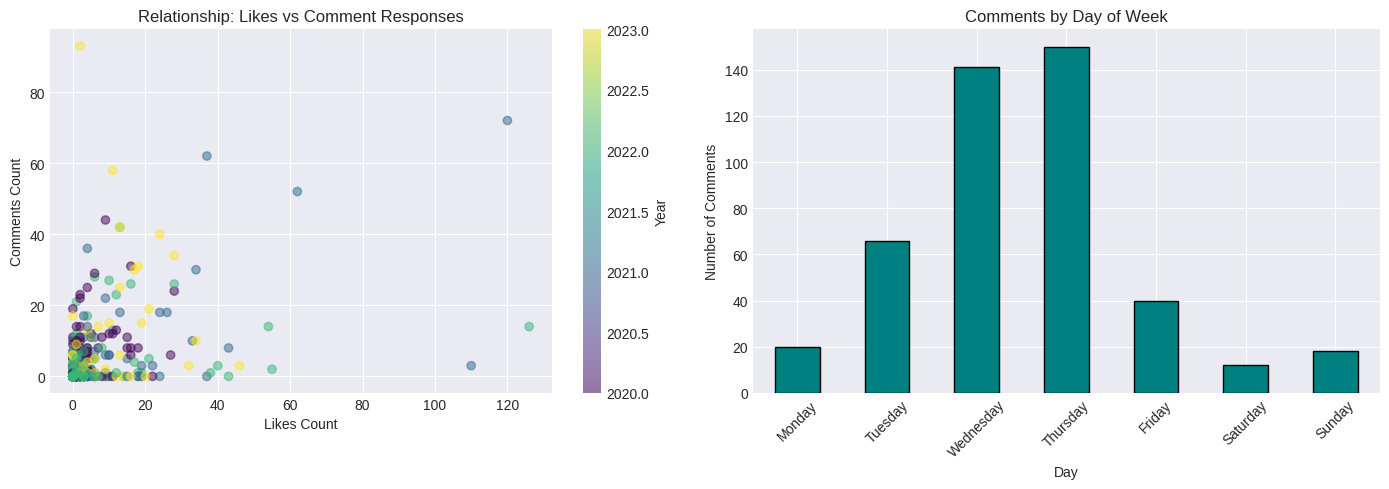

In [8]:
# 4.1 Temporal Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Comments over time
df.groupby(df['date'].dt.to_period('M')).size().plot(ax=axes[0, 0],
                                                       color='steelblue')
axes[0, 0].set_title('Number of Comments Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Comments')
axes[0, 0].grid(True, alpha=0.3)

# Likes distribution
df['likesCount'].hist(bins=50, ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_title('Distribution of Likes', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Likes')
axes[0, 1].set_ylabel('Frequency')

# Comments by year
df['year'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0],
                                             color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Comments by Year', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Comments')
axes[1, 0].tick_params(axis='x', rotation=0)

# Word count distribution
df['word_count'].hist(bins=50, ax=axes[1, 1], color='plum', edgecolor='black')
axes[1, 1].set_title('Distribution of Comment Length', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4.2 Engagement Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top engaged comments
top_liked = df.nlargest(10, 'likesCount')[['text', 'likesCount', 'date']]
print("\n📊 Top 10 Most Liked Comments:")
print(top_liked)

# Correlation between likes and comment count
scatter = axes[0].scatter(df['likesCount'], df['commentsCount'],
                          alpha=0.5, c=df['year'], cmap='viridis')
axes[0].set_xlabel('Likes Count')
axes[0].set_ylabel('Comments Count')
axes[0].set_title('Relationship: Likes vs Comment Responses')
plt.colorbar(scatter, ax=axes[0], label='Year')

# Comments by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'].value_counts()[day_order].plot(kind='bar', ax=axes[1],
                                                   color='teal', edgecolor='black')
axes[1].set_title('Comments by Day of Week')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of Comments')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

5. SENTIMENT ANALYSIS


🔍 Performing Sentiment Analysis...
✅ Sentiment analysis completed!


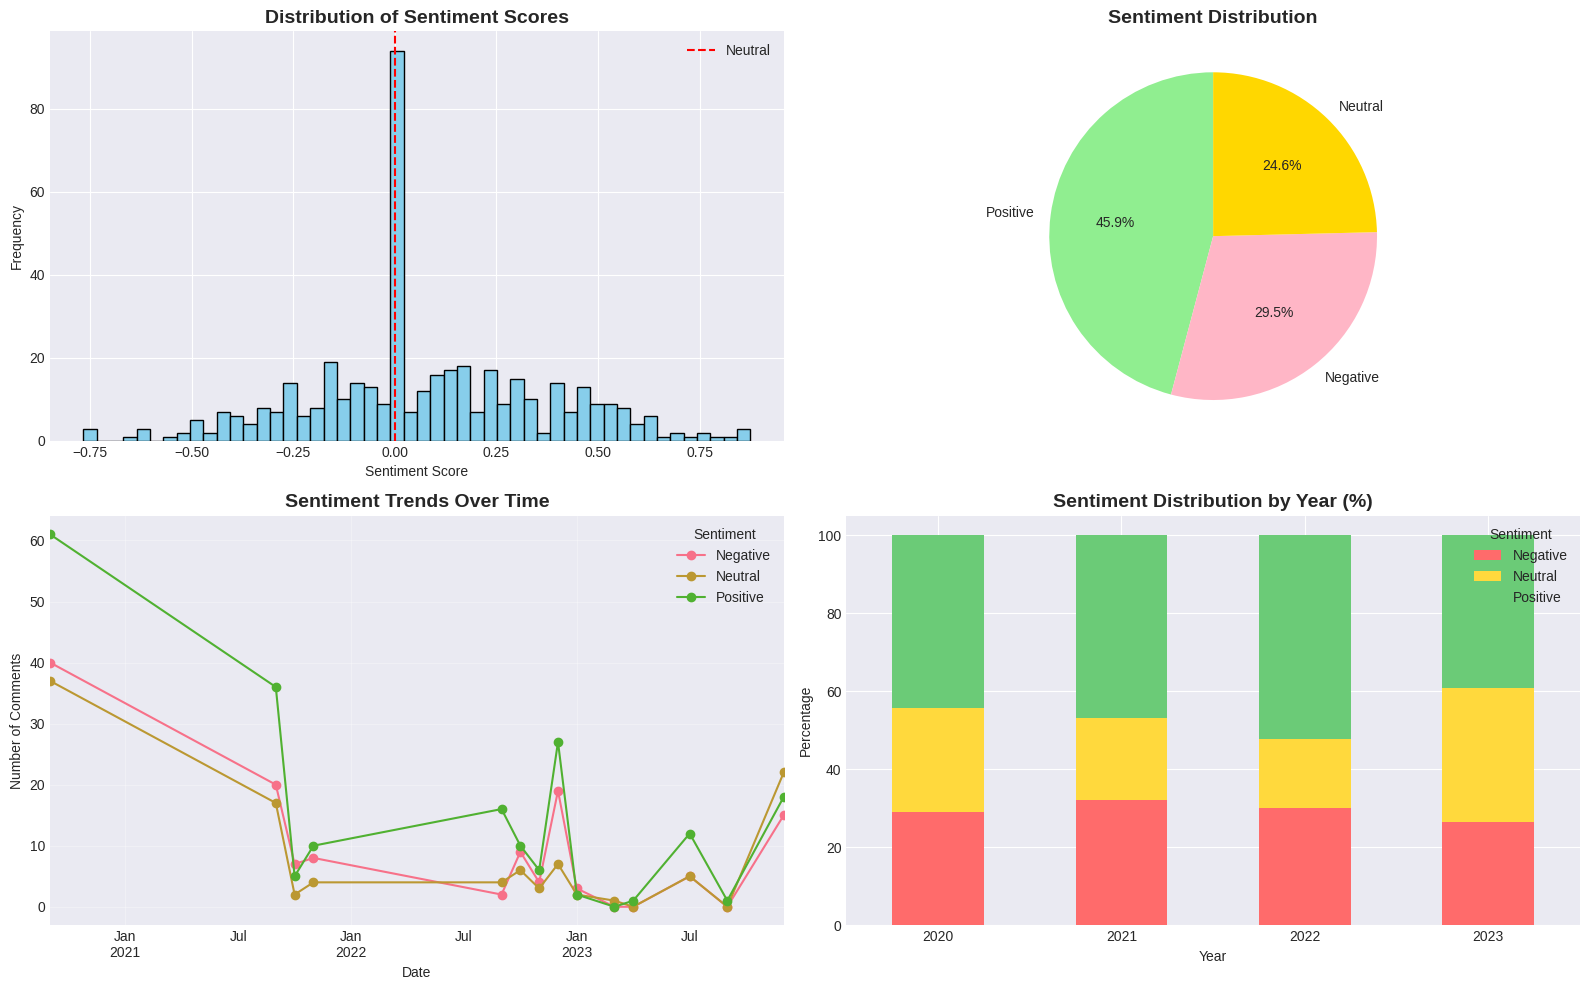


📊 Sentiment Statistics:
Average Sentiment Score: 0.075

Sentiment Distribution:
sentiment_category
Positive    205
Negative    132
Neutral     110
Name: count, dtype: int64

Sentiment by Year:
sentiment_category  Negative  Neutral  Positive
year                                           
2020                      40       37        61
2021                      35       23        51
2022                      34       20        59
2023                      23       30        34


In [9]:
print("\n🔍 Performing Sentiment Analysis...")

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()

def get_textblob_sentiment(text):
    """Get sentiment using TextBlob"""
    if not text:
        return 0
    blob = TextBlob(text)
    return blob.sentiment.polarity

def get_vader_sentiment(text):
    """Get sentiment using VADER"""
    if not text:
        return 0
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']

def categorize_sentiment(score):
    """Categorize sentiment score"""
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis
df['textblob_score'] = df['cleaned_text'].apply(get_textblob_sentiment)
df['vader_score'] = df['cleaned_text'].apply(get_vader_sentiment)

# Average both scores
df['sentiment_score'] = (df['textblob_score'] + df['vader_score']) / 2
df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

print("✅ Sentiment analysis completed!")

# Sentiment Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Sentiment score distribution
df['sentiment_score'].hist(bins=50, ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Sentiment Scores', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(x=0, color='red', linestyle='--', label='Neutral')
axes[0, 0].legend()

# Sentiment category counts
sentiment_counts = df['sentiment_category'].value_counts()
axes[0, 1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
               colors=['#90EE90', '#FFB6C6', '#FFD700'], startangle=90)
axes[0, 1].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')

# Sentiment over time
sentiment_time = df.groupby([df['date'].dt.to_period('M'), 'sentiment_category']).size().unstack(fill_value=0)
sentiment_time.plot(ax=axes[1, 0], marker='o')
axes[1, 0].set_title('Sentiment Trends Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Number of Comments')
axes[1, 0].legend(title='Sentiment')
axes[1, 0].grid(True, alpha=0.3)

# Sentiment by year
sentiment_year = pd.crosstab(df['year'], df['sentiment_category'], normalize='index') * 100
sentiment_year.plot(kind='bar', stacked=True, ax=axes[1, 1],
                    color=['#FF6B6B', '#FFD93D', '#6BCB77'])
axes[1, 1].set_title('Sentiment Distribution by Year (%)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].legend(title='Sentiment')

plt.tight_layout()
plt.show()

# Print sentiment statistics
print("\n📊 Sentiment Statistics:")
print(f"Average Sentiment Score: {df['sentiment_score'].mean():.3f}")
print(f"\nSentiment Distribution:")
print(df['sentiment_category'].value_counts())
print(f"\nSentiment by Year:")
print(pd.crosstab(df['year'], df['sentiment_category']))

6. TOPIC MODELING


🔍 Performing Topic Modeling...

📚 Discovered Topics:

Topic 1:
global, cooling, cold, life, ever, getting, graph, happened, happen, temperature

Topic 2:
years, people, deniers, think, going, weather, dont, cause, earth, last

Topic 3:
data, real, scientists, things, post, someone, trying, believe, late, based

Topic 4:
warming, global, science, carbon, fake, people, planet, water, earth, understand

Topic 5:
good, help, temperature, years, point, heat, effect, comments, warming, degree


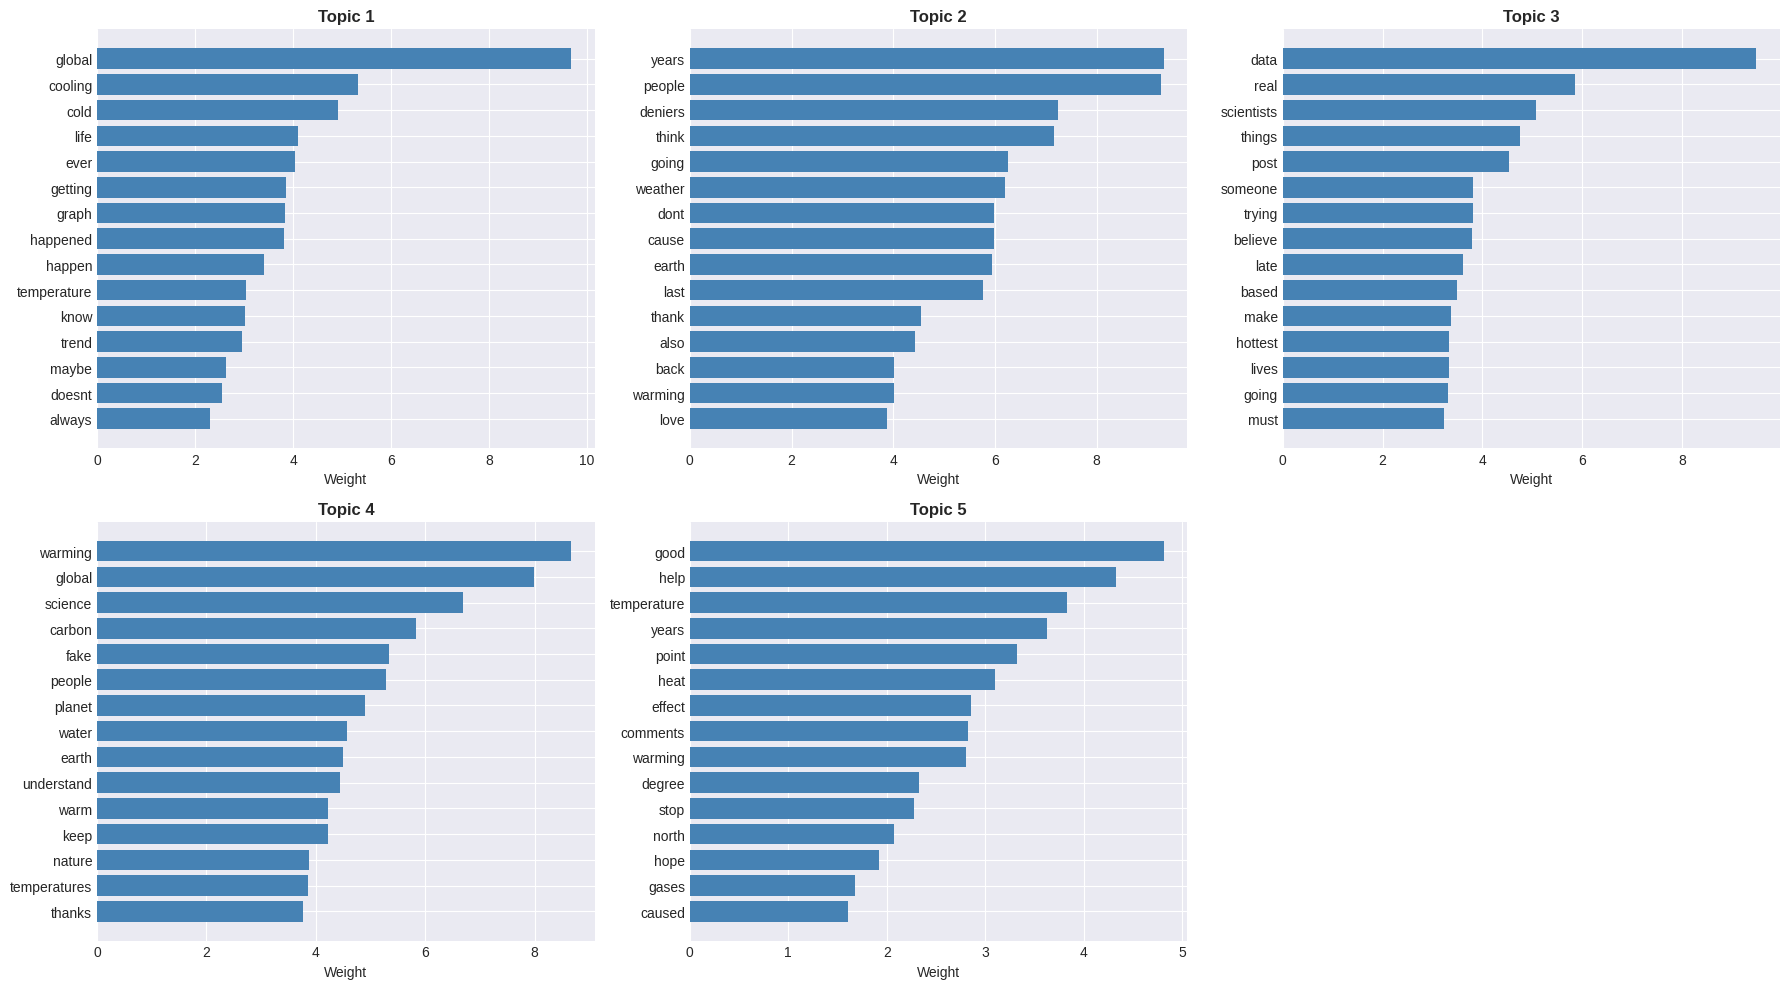


✅ Topic modeling completed!


In [10]:
print("\n🔍 Performing Topic Modeling...")

# Prepare text for topic modeling
stop_words = set(stopwords.words('english'))
stop_words.update(['climate', 'change', 'nasa', 'would', 'could', 'like', 'one'])

def preprocess_for_topics(text):
    """Preprocess text for topic modeling"""
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) > 3]
    return ' '.join(tokens)

df['topic_text'] = df['cleaned_text'].apply(preprocess_for_topics)

# Remove empty documents
df_topics = df[df['topic_text'].str.len() > 10].copy()

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000, max_df=0.8, min_df=5)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_topics['topic_text'])

# Apply LDA for topic modeling
n_topics = 5
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42,
                                       max_iter=20, learning_method='online')
lda_topics = lda_model.fit_transform(tfidf_matrix)

# Get top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, n_top_words=10):
    """Display top words for each topic"""
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[f'Topic {topic_idx + 1}'] = top_words
    return topics

topics_dict = display_topics(lda_model, feature_names, n_top_words=10)

print("\n📚 Discovered Topics:")
for topic_name, words in topics_dict.items():
    print(f"\n{topic_name}:")
    print(", ".join(words))

# Visualize topics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for topic_idx, ax in enumerate(axes[:n_topics]):
    top_words_idx = lda_model.components_[topic_idx].argsort()[-15:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    weights = lda_model.components_[topic_idx][top_words_idx]

    ax.barh(range(len(top_words)), weights, color='steelblue')
    ax.set_yticks(range(len(top_words)))
    ax.set_yticklabels(top_words)
    ax.set_xlabel('Weight')
    ax.set_title(f'Topic {topic_idx + 1}', fontsize=12, fontweight='bold')
    ax.invert_yaxis()

# Remove extra subplot
if len(axes) > n_topics:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Assign dominant topic to each comment
df_topics['dominant_topic'] = lda_topics.argmax(axis=1)
df_topics['topic_probability'] = lda_topics.max(axis=1)

print("\n✅ Topic modeling completed!")

7. WORD CLOUD VISUALIZATION


☁️ Generating Word Clouds...


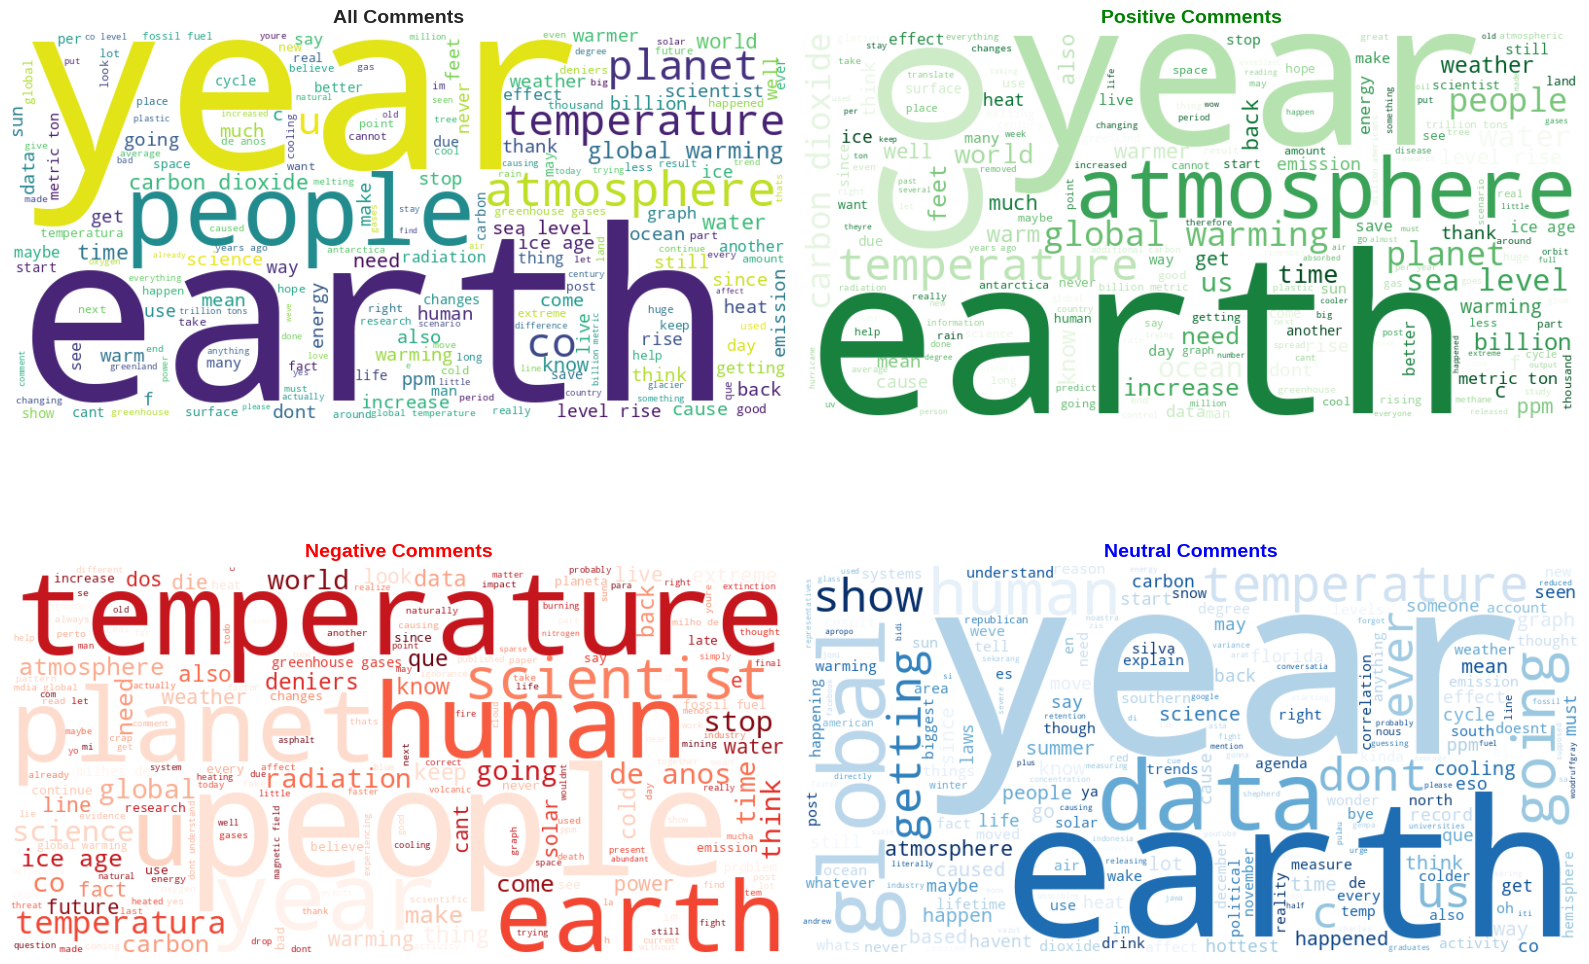

In [11]:
print("\n☁️ Generating Word Clouds...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall word cloud
all_text = ' '.join(df['cleaned_text'])
wordcloud_all = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stop_words, colormap='viridis').generate(all_text)
axes[0, 0].imshow(wordcloud_all, interpolation='bilinear')
axes[0, 0].set_title('All Comments', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Positive sentiment word cloud
positive_text = ' '.join(df[df['sentiment_category'] == 'Positive']['cleaned_text'])
if positive_text:
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                             stopwords=stop_words, colormap='Greens').generate(positive_text)
    axes[0, 1].imshow(wordcloud_pos, interpolation='bilinear')
axes[0, 1].set_title('Positive Comments', fontsize=14, fontweight='bold', color='green')
axes[0, 1].axis('off')

# Negative sentiment word cloud
negative_text = ' '.join(df[df['sentiment_category'] == 'Negative']['cleaned_text'])
if negative_text:
    wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                             stopwords=stop_words, colormap='Reds').generate(negative_text)
    axes[1, 0].imshow(wordcloud_neg, interpolation='bilinear')
axes[1, 0].set_title('Negative Comments', fontsize=14, fontweight='bold', color='red')
axes[1, 0].axis('off')

# Neutral sentiment word cloud
neutral_text = ' '.join(df[df['sentiment_category'] == 'Neutral']['cleaned_text'])
if neutral_text:
    wordcloud_neu = WordCloud(width=800, height=400, background_color='white',
                             stopwords=stop_words, colormap='Blues').generate(neutral_text)
    axes[1, 1].imshow(wordcloud_neu, interpolation='bilinear')
axes[1, 1].set_title('Neutral Comments', fontsize=14, fontweight='bold', color='blue')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

8. KEYWORD AND PHRASE ANALYSIS


🔑 Analyzing Key Phrases...


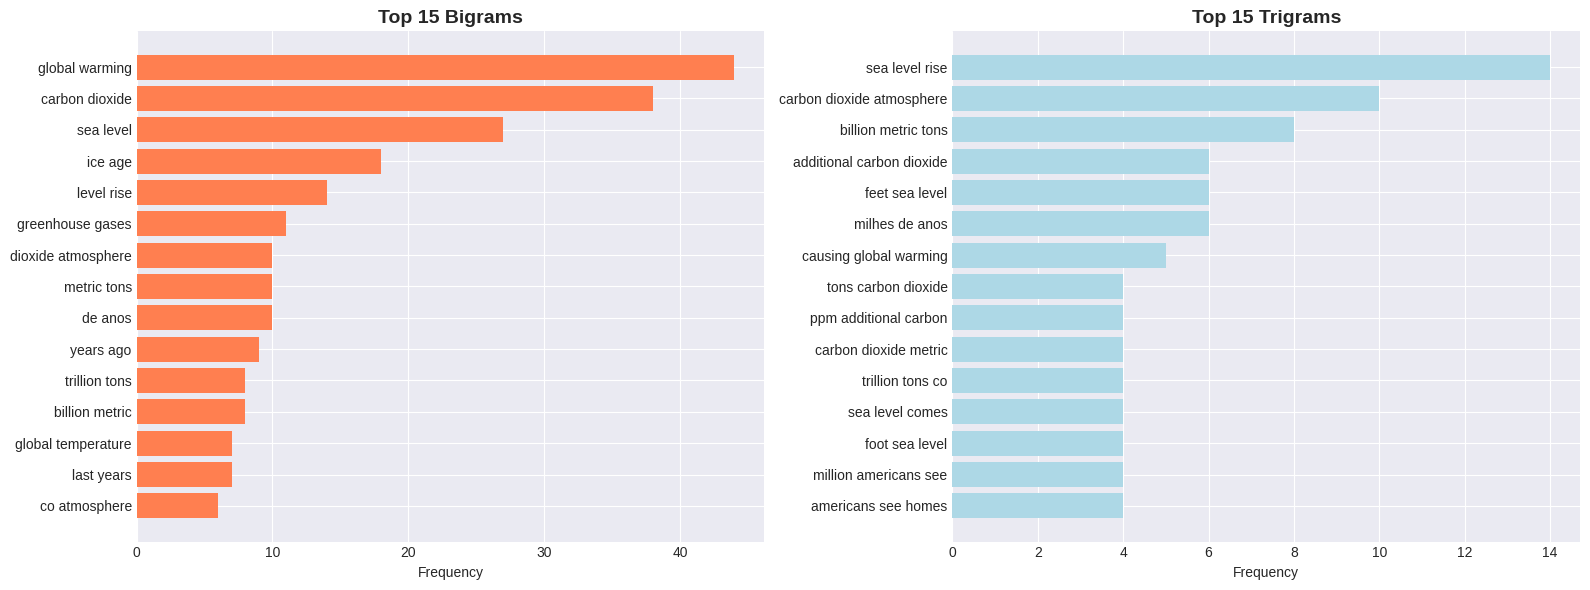

In [12]:
print("\n🔑 Analyzing Key Phrases...")

# Common bigrams and trigrams
from nltk import ngrams

def get_top_ngrams(text_series, n=2, top=20):
    """Get top n-grams"""
    all_ngrams = []
    for text in text_series:
        tokens = word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        all_ngrams.extend(list(ngrams(tokens, n)))

    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top)

# Get top bigrams
top_bigrams = get_top_ngrams(df['cleaned_text'], n=2, top=15)
top_trigrams = get_top_ngrams(df['cleaned_text'], n=3, top=15)

# Visualize bigrams and trigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bigrams
bigram_labels = [' '.join(bg) for bg, _ in top_bigrams]
bigram_counts = [count for _, count in top_bigrams]
axes[0].barh(range(len(bigram_labels)), bigram_counts, color='coral')
axes[0].set_yticks(range(len(bigram_labels)))
axes[0].set_yticklabels(bigram_labels)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Bigrams', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Trigrams
trigram_labels = [' '.join(tg) for tg, _ in top_trigrams]
trigram_counts = [count for _, count in top_trigrams]
axes[1].barh(range(len(trigram_labels)), trigram_counts, color='lightblue')
axes[1].set_yticks(range(len(trigram_labels)))
axes[1].set_yticklabels(trigram_labels)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Trigrams', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

9. MACHINE LEARNING - SENTIMENT CLASSIFICATION


🤖 Building Sentiment Classification Model...

📊 Model Performance:

Classification Report:
              precision    recall  f1-score   support

    Negative       0.55      0.22      0.32        27
     Neutral       0.29      0.23      0.26        22
    Positive       0.48      0.73      0.58        41

    accuracy                           0.46        90
   macro avg       0.44      0.39      0.38        90
weighted avg       0.46      0.46      0.42        90



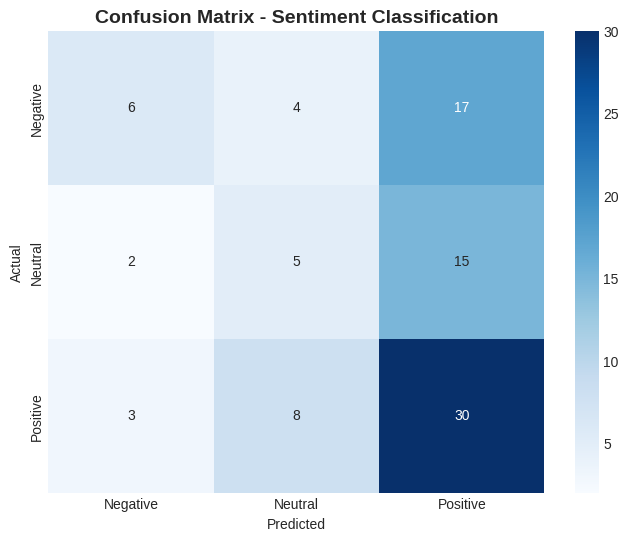

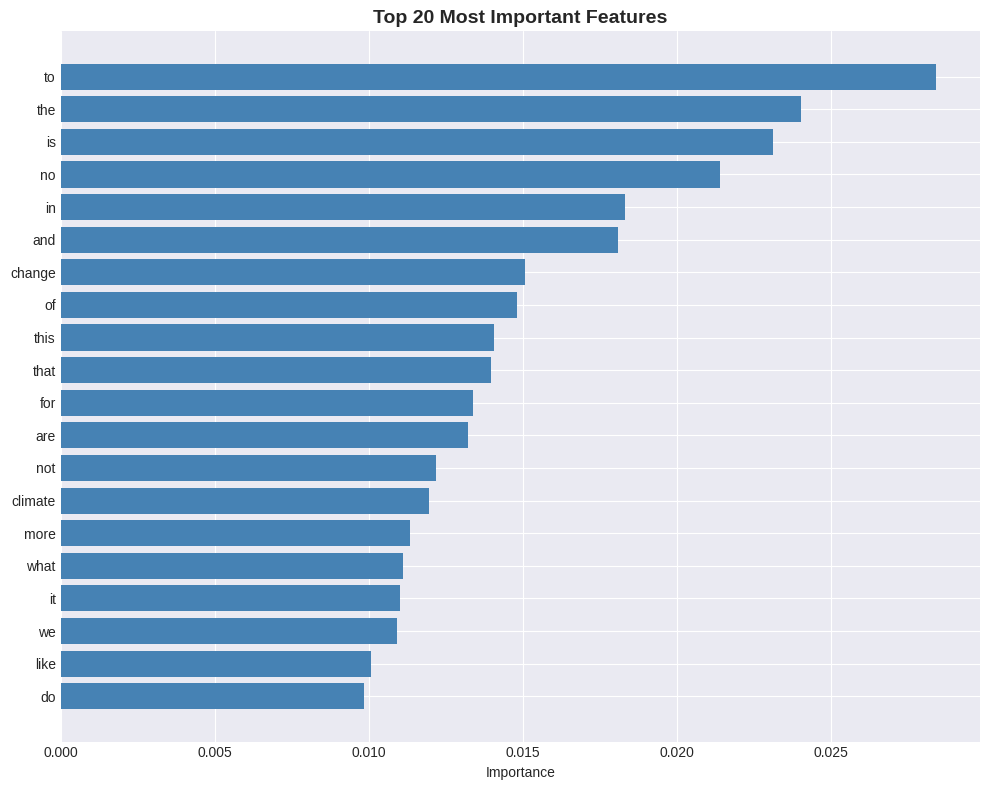

In [13]:
print("\n🤖 Building Sentiment Classification Model...")

# Prepare data for ML
df_ml = df[['cleaned_text', 'sentiment_category']].copy()
df_ml = df_ml[df_ml['cleaned_text'].str.len() > 10]

# Encode labels
le = LabelEncoder()
df_ml['sentiment_encoded'] = le.fit_transform(df_ml['sentiment_category'])

# Create TF-IDF features
tfidf_vec = TfidfVectorizer(max_features=500, min_df=5, max_df=0.8)
X = tfidf_vec.fit_transform(df_ml['cleaned_text'])
y = df_ml['sentiment_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42, stratify=y)

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("\n📊 Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Sentiment Classification', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': tfidf_vec.get_feature_names_out(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

10. INSIGHTS AND CONCLUSIONS

In [14]:
print("\n" + "="*80)
print("📊 KEY INSIGHTS AND FINDINGS")
print("="*80)

print(f"\n1. DATASET OVERVIEW:")
print(f"   - Total comments analyzed: {len(df)}")
print(f"   - Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"   - Average comment length: {df['word_count'].mean():.1f} words")

print(f"\n2. SENTIMENT ANALYSIS:")
print(f"   - Overall sentiment: {df['sentiment_score'].mean():.3f}")
sentiment_pct = df['sentiment_category'].value_counts(normalize=True) * 100
for sentiment, pct in sentiment_pct.items():
    print(f"   - {sentiment}: {pct:.1f}%")

print(f"\n3. ENGAGEMENT PATTERNS:")
print(f"   - Average likes per comment: {df['likesCount'].mean():.1f}")
print(f"   - Most active year: {df['year'].value_counts().idxmax()}")
print(f"   - Most active day: {df['day_of_week'].value_counts().idxmax()}")

print(f"\n4. TOPIC MODELING:")
print(f"   - Number of topics discovered: {n_topics}")
print(f"   - Average topic confidence: {df_topics['topic_probability'].mean():.3f}")

print(f"\n5. ML MODEL PERFORMANCE:")
print(f"   - Test accuracy: {(y_pred == y_test).mean():.3f}")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)


📊 KEY INSIGHTS AND FINDINGS

1. DATASET OVERVIEW:
   - Total comments analyzed: 447
   - Date range: 2020-09-15 to 2023-12-25
   - Average comment length: 34.9 words

2. SENTIMENT ANALYSIS:
   - Overall sentiment: 0.075
   - Positive: 45.9%
   - Negative: 29.5%
   - Neutral: 24.6%

3. ENGAGEMENT PATTERNS:
   - Average likes per comment: 5.4
   - Most active year: 2020
   - Most active day: Thursday

4. TOPIC MODELING:
   - Number of topics discovered: 5
   - Average topic confidence: 0.611

5. ML MODEL PERFORMANCE:
   - Test accuracy: 0.456

✅ ANALYSIS COMPLETE!


11. SAVE RESULTS

In [15]:
# Save processed data with sentiment and topics
df_final = df.copy()
if 'dominant_topic' in df_topics.columns:
    df_final = df_final.merge(df_topics[['dominant_topic', 'topic_probability']],
                               left_index=True, right_index=True, how='left')

df_final.to_csv('climate_comments_analyzed.csv', index=False)
print("\n💾 Results saved to 'climate_comments_analyzed.csv'")

print("\n🎉 Project completed successfully!")


💾 Results saved to 'climate_comments_analyzed.csv'

🎉 Project completed successfully!
